# Otimização de código 

Python possui diversas bibliotecas para computação numérica que são eficientes e de alto desempenho, tais como _numpy_ e _scipy_. A computação de alta performance é atingida não por Python puro, mas pelo aproveitamento de bibliotecas que são compiladas externamente. 

Às vezes, temos necessidade de desenvolver código do zero usando puramente Python. Entretanto, essa escolha pode levar a códigos lentos. A solução é escrever rotinas em linguages externas, tais como C, C++ ou Fortran que façam os cálculos que consomem mais tempo e criar interfaces entre elas e o código Puython.

Existem métodos que permitem criar módulos de extensão para Python, tais como: 

- módulo _ctypes_
- API Python para C 
- CFFI (C foreign function interface)

Embora úteis, todas elas exigem conhecimento aprofundado de outras linguagens e são mais úteis para códigos-fonte já escritos nessas linguagens. Algumas alternativas de desenvolvimento que se aproximam de Python que valem a pena ser consideradas antes de partirmos para uma implementação direta em linguagem complicada existem. Duas delas são: _numba_ e _cython_.

## _numba_

[[Numba]](https://numba.pydata.org) é um compilador *just-in-time* (JIT) para código Python usando _numpy_ que produz código de máquina executável de forma mais eficiente do que o código Python original. Para conseguir isso, _numba_ aproveita o conjunto de compiladores [[LLVM]](http://llvm.org), que se tornou muito popular nos últimos anos por seu design e interface modular e reutilizável. 

## _cython_

[[Cython]](http://cython.org) é um superconjunto da linguagem Python que pode ser traduzido automaticamente para C ou C++ e compilado em um código de máquina executável de modo muito mais rápido do que o código Python. Cython é amplamente utilizado em projetos Python orientados computacionalmente para acelerar partes críticas de tempo de um código que é escrita em Python. Várias bibliotecas dependem muito do Cython. Isso inclui NumPy, SciPy, Pandas e scikit-learn, apenas para mencionar algumas.

Veremos como usar _numba_ e _cython_ para acelerar códigos originalmente escritos em Python. É recomendado que se faça um perfilamento de código com o módulo `cProfile` ou outras ferramentas para identificar gargalos de cálculo antes de tentarmos otimizar algo.

## Exemplos com numba

In [3]:
import numba
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Não precisamos alterar o código-alvo a ser acelerado. Basta usar o JIT do Numba como "decorador" `@numba.jit` para uma função.

### Soma de elementos em um array

Consideramos o seguinte código simples.

In [4]:
def py_sum(val):
    s = 0
    for v in val:
        s += v
    return s

In [8]:
val = np.random.rand(50000) # 50000 aleatórios
%timeit py_sum(val) 

6.91 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


A versão vetorizada da somatória é mais rápida.

In [9]:
%timeit np.sum(val)

22.6 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Teste da função. Se assert não lança erro, temos a condição válida.

In [18]:
assert abs(py_sum(val) - np.sum(val)) < 1e-9

Tratando com numba.

In [19]:
@numba.jit
def jit_sum(val):
    s = 0
    for v in val:
        s += v
    return s

In [22]:
assert abs(jit_sum(val) - np.sum(val)) < 1e-9 # função numba produz mesmo valor

In [23]:
%timeit jit_sum(val)

46.5 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Comparando isto com a implementação pura, temos uma grande diferença.

### Soma cumulativa

In [26]:
def py_cumsum(val):
    o = np.zeros_like(val)
    s= 0
    for n in range(len(val)):
        s += val[n]
        o[n] = s
    return o

In [28]:
%timeit py_cumsum(val)

16.8 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit np.cumsum(val)

149 µs ± 4.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Utilizando numba:

In [30]:
@numba.jit
def jit_cumsum(val):
    o = np.zeros_like(val)
    s= 0
    for n in range(len(val)):
        s += val[n]
        o[n] = s
    return o

In [31]:
%timeit jit_cumsum(val)

62.3 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Fractal de Julia

O fractal de Julia exige um número variável de iterações para cada elemento de uma matriz com coordenadas no plano complexo:

- Um ponto $z$ no plano complexo pertence ao conjunto de Julia se a fórmula de iteração $z \leftarrow z^2 + c$ não diverge após um número grande de iterações.

In [32]:
def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n] 
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j 
                if np.abs(z) > 2.0:
                    j[m, n] = t 
                    break

Decorador:

In [33]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal) # nopython : 

Chamada da função:

In [34]:
N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N) 
z_imag = np.linspace(-1.5, 1.5, N) 
jit_julia_fractal(z_real, z_imag, j)

Visualização do fractal gerado por Numba:

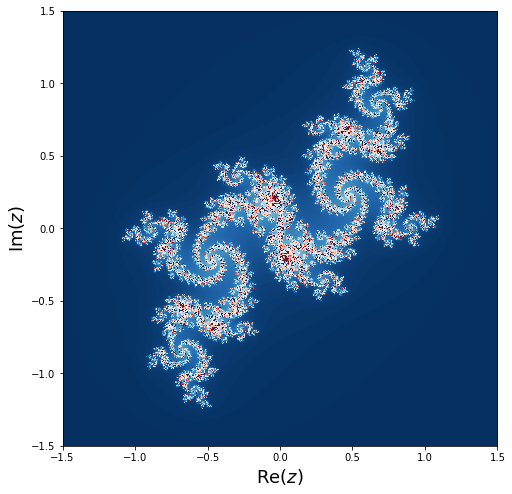

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(j, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18);

Comparação do tempo em cada chamada:

In [37]:
%timeit py_julia_fractal(z_real, z_imag, j)

56.7 s ± 2.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit jit_julia_fractal(z_real, z_imag, j)

141 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### `numba.vectorize`

Aqui, vamos construir a função de Heaviside:

In [39]:
def py_Heaviside(x):
    if x == 0.0: 
        return 0.5
    if x < 0.0: 
        return 0.0    
    else:
        return 1.0

In [40]:
x = np.linspace(-2, 2, 50001)
%timeit [py_Heaviside(xx) for xx in x]

17.2 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Para ter a função aplicada elemento a elemento em um array, fazemos:

In [46]:
np_vec_Heaviside = np.vectorize(py_Heaviside)
np_vec_Heaviside(x)

array([0., 0., 0., ..., 1., 1., 1.])

A função `vectorize` não resolve o problema com a performance.

In [47]:
%timeit np_vec_Heaviside(x)

8.25 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Melhor performance é atingida com:

In [48]:
def np_Heaviside(x):
    return (x > 0.0) + (x == 0.0)/2.0

In [49]:
%timeit np_Heaviside(x)

194 µs ± 4.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Um desempenho ainda melhor pode ser alcançado usando Numba e o decorador `vectorize`, que obtém uma lista de assinaturas de função para a qual gerar o código compilado por JIT. 

Aqui, escolhemos gerar funções vetorizadas para duas assinaturas - uma que recebe matrizes de números de ponto flutuante de 32 bits como entrada e saída, definidos como `numba.float32`, e um que recebe matrizes de números de ponto flutuante de 64 bits como entrada e saída, definido como `numba.float64`:

In [50]:
@numba.vectorize([numba.float32(numba.float32), numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0: 
        return 0.5
    if x < 0.0: 
        return 0.0    
    else:
        return 1.0

In [51]:
%timeit jit_Heaviside(x)

31.4 µs ± 650 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
